# Local coordinate aperture photometry for input to DSLR data worksheet

## Definitions

### Imports

In [22]:
import os
from random import random
from collections import OrderedDict

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.visualization import astropy_mpl_style

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
plt.style.use(astropy_mpl_style)
%matplotlib inline

from PythonPhot import aper

### Functions

#### Photometry of a list of FITS files, creating a table of times and instrumental magnitudes

In [13]:
def multi_file_photometry(fits_root, fits_files, data_index, coords, dataframe, 
                          aperture_radius, inner_sky_radius, outer_sky_radius, 
                          gain=1, zeropoint=0, suffix='.fit'):
    
    for fits_file in fits_files:
        fits_file_path = os.path.join(fits_root, fits_file)
        hdus = fits.open(fits_file_path)
            
        instr_mags = []
        for x, y in coords:
            time, mag = aperture_photometry(hdus[data_index], x, y, 
                                            aperture_radius, inner_sky_radius, outer_sky_radius,
                                            gain=gain, zeropoint=zeropoint)
            instr_mags.append(mag)
        
        dataframe[fits_file[0:fits_file.rindex(suffix)]] = [time] + instr_mags  

#### Single image+coordinate photometry, returning a time and instrumental magnitude. Invoked by multi_file_photometry()

In [14]:
def aperture_photometry(hdu, x, y, 
                        aperture_radius, inner_sky_radius, outer_sky_radius, 
                        gain=1, zeropoint=0):

    image_data = hdu.data
    time = hdu.header[time_name]
        
    mag, magerr, flux, fluxerr, sky, skyerr, badflag, outstr = \
                aper.aper(image_data, x, y, phpadu=gain, 
                          apr=aperture_radius, zeropoint=zeropoint,
                          skyrad=[inner_sky_radius, outer_sky_radius], 
                          exact=True)

    return time, mag[0]

#### Display an image with target and reference stars annotated, to sanity check local coordinates

In [15]:
def show_image(image_data, coord_map, aperture_size, vmin=10, vmax=200, figx=20, figy=10):
    fig = plt.figure(figsize=(figx, figy))
    plt.imshow(image_data, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().invert_yaxis()
    plt.colorbar()

    for designation in coord_map:
        xy = coord_map[designation]
        annotate_image(fig.axes[0], designation, xy, aperture_size)
    
    plt.show()

#### Annotate plot axis with coordinate positions and designations. Invoked by show_image()

In [51]:
def annotate_image(axis, designation, xy, aperture_size):
    axis.plot(xy[0], xy[1], 'o', markersize=aperture_size, 
              markeredgecolor='r', markerfacecolor='none', 
              markeredgewidth=2)
    
    offsetbox = TextArea(designation, minimumdescent=False)

    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(-20, 40+random()*10-10),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    
    axis.add_artist(ab)        

## Inputs
### Change these to suit your environment

#### File settings

In [52]:
# Instrumental magnitude output file path
instr_mag_file_root = "/Users/david/_photometry_working"
instr_mag_csv_file = "instr_mags.csv"

# FITS file directory
fits_root = "/Users/david/_photometry_working"

# B, G, and R FITS file prefixes to identify files,
# e.g. stk-median-g matches stk-median-g1.fit, stk-median-g2.fit, ... 
fits_prefixes = ["stk-median-b", "stk-median-g", "stk-median-r"]

# FITS file data HDU index
data_index = 0

# Time column name
time_name = "JD"

#### Map of object designations to local coordinates

In [53]:
# Ordered dictionary of object names/IDs to local coordinates
position_map = OrderedDict({
 # ** Your name-tuple pairs go here **
 "Nova Cir 2018":(2005.586,1261.529),
 "61 000-BKS-959 (CHK)":(1236.912,2213.747),
 "70 000-BFT-998":(2220.389,2254.417),
 "71":(975.905,2270.083),
 "72":(831.322,1293.634),
 "73":(2178.212,2322.509),
 "58":(1132.404,1833.450),
 "64 000-BKT-761":(1518.255,1998.064)
 # ** END **
})

#### Aperture radii and gain

In [54]:
# Aperture radii
measurement_aperture = 12
inner_sky_annulus = 15
outer_sky_annulus = 20

# ph/ADU
# Note: PythonPhot's aperture photometry function takes a phadu parameter.
# Assumption: this is photons/ADU or e-/ADU, i.e. gain.
gain=1.67

## Outputs

### Find B, G, R files in the FITS file directory

In [55]:
files = os.listdir(fits_root)

fits_files = []
for fits_prefix in fits_prefixes:
    fits_files += sorted([file for file in files if fits_prefix in file])

### Aperture location sanity check by visual inspection
#### Arbitrarily choose the first G FITS file

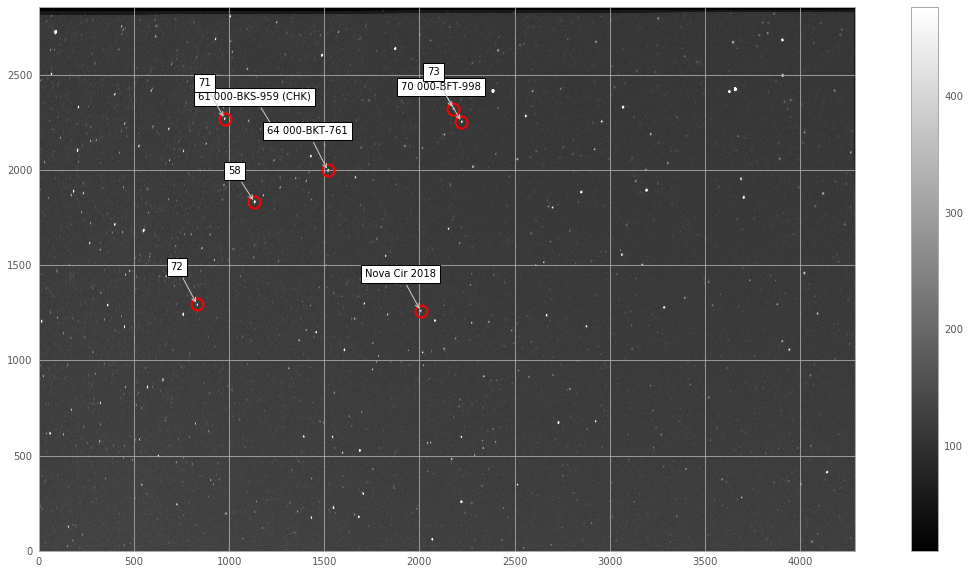

In [59]:
fits_file = fits_files[0]

hdus = fits.open(os.path.join(fits_root, fits_file))
image_data = hdus[data_index].data

median = np.median(image_data)
show_image(image_data, position_map, measurement_aperture, vmin=10, vmax=median*4)

### Aperture photometry

In [46]:
# Create empty table with time and object headers
pd.options.display.float_format = '{:,.6f}'.format
instr_mag_df = pd.DataFrame()
names = [name for name in position_map]
instr_mag_df['name'] = [time_name] + names
instr_mag_df.set_index('name', inplace=True)

In [47]:
# Carry out photometry on B, G, R FITS files, yielding instrumental magnitudes
positions = position_map.values()

multi_file_photometry(fits_root, fits_files, data_index, positions, instr_mag_df, 
                      measurement_aperture, inner_sky_annulus, outer_sky_annulus, gain=1.67)

In [48]:
# Save photometry table as CSV
instr_mag_csv_path = os.path.join(instr_mag_file_root, instr_mag_csv_file)
instr_mag_df.T.to_csv(instr_mag_csv_path)

# Display photometry table
instr_mag_df.T

name,JD,Nova Cir 2018,61 000-BKS-959 (CHK),70 000-BFT-998,71,72,73,58,64 000-BKT-761
stk-median-b1,"2,458,183.054372",-10.936122,-12.226636,-11.376007,-11.240794,-11.152725,-11.114621,-12.338111,-12.053087
stk-median-b2,"2,458,183.055773",-10.951321,-12.226987,-11.391650,-11.282804,-11.194527,-11.171259,-12.378085,-12.067869
stk-median-b3,"2,458,183.057170",-10.948729,-12.216107,-11.367913,-11.271452,-11.171218,-11.140876,-12.395330,-12.056749
stk-median-b4,"2,458,183.058573",-10.925663,-12.247619,-11.362623,-11.265393,-11.140310,-11.180696,-12.377571,-12.072831
stk-median-b5,"2,458,183.059977",-11.012921,-12.236997,-11.393773,-11.280969,-11.156724,-11.178387,-12.401094,-12.057739
stk-median-g1,"2,458,183.054372",-11.173714,-12.354888,-11.429736,-11.356995,-11.270210,-11.222986,-12.641152,-12.138837
stk-median-g2,"2,458,183.055773",-11.174641,-12.364281,-11.456066,-11.405596,-11.352180,-11.244664,-12.659380,-12.139048
stk-median-g3,"2,458,183.057170",-11.190757,-12.362519,-11.456707,-11.428510,-11.307725,-11.223139,-12.669232,-12.124679
stk-median-g4,"2,458,183.058573",-11.204749,-12.373818,-11.434652,-11.372530,-11.292781,-11.253753,-12.654926,-12.149203
stk-median-g5,"2,458,183.059977",-11.186848,-12.344608,-11.451795,-11.402283,-11.312615,-11.245524,-12.681856,-12.146659


## References
* http://docs.astropy.org/en/stable/io/fits
* http://docs.astropy.org/en/stable/generated/examples/io/plot_fits-image.html
* http://www.astropy.org/astropy-tutorials/FITS-images.html
* https://github.com/djones1040/PythonPhot